In [1]:
import tensorflow as tf
print(tf.__version__)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import sys
sys.path.append("..")
import keras_utils
import tqdm_utils

1.2.1


Using TensorFlow backend.


In [14]:
start_token = " " 
pad_token = "#"

with open("names") as f:
    names = f.read()[:-1].split('\n')
    names = [start_token + name for name in names]

In [15]:
print('number of samples:', len(names))
for x in names[::1000]:
    print(x)

number of samples: 7944
 Abagael
 Claresta
 Glory
 Liliane
 Prissie
 Geeta
 Giovanne
 Piggy


max length: 16


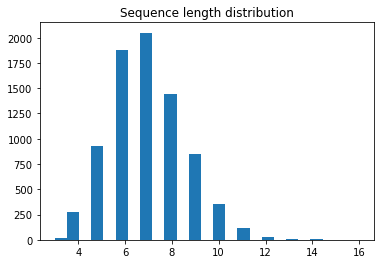

In [16]:
MAX_LENGTH = max(map(len, names))
print("max length:", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, names)), bins=25);

In [17]:
tokens = list(set(''.join(names)))

tokens = list(tokens)
n_tokens = len(tokens)
print ('n_tokens:', n_tokens)

assert 50 < n_tokens < 60

n_tokens: 55


In [19]:
token_to_id ={}
for j in range(n_tokens):
    token_to_id[tokens[j]]=j
assert len(tokens) == len(token_to_id), 

In [21]:
def to_matrix(names, max_len=None, pad=0, dtype=np.int32):
    
    max_len = max_len or max(map(len, names))
    names_ix = np.zeros([len(names), max_len], dtype) + pad

    for i in range(len(names)):
        name_ix = list(map(token_to_id.get, names[i]))
        names_ix[i, :len(name_ix)] = name_ix

    return names_ix

In [22]:

print('\n'.join(names[::2000]))
print(to_matrix(names[::2000]))

 Abagael
 Glory
 Prissie
 Giovanne
[[30 36 13 28 39 28 33 31  0]
 [30 41 31 42 24  9  0  0  0]
 [30  4 24  5  3  3  5 33  0]
 [30 41  5 42 53 28 11 11 33]]


In [23]:
s = keras_utils.reset_tf_session()

In [26]:
import keras
from keras.layers import concatenate, Dense, Embedding

rnn_num_units = 64 
embedding_size = 16  
embed_x = Embedding(n_tokens, embedding_size)

get_h_next = Dense(rnn_num_units,activation='relu')

get_probas = Dense(n_tokens,activation='softmax')

We will generate names character by character starting with `start_token`:

<img src="./char-nn.png" width=600>

In [27]:
def rnn_one_step(x_t, h_t):

    x_t_emb = embed_x(tf.reshape(x_t, [-1, 1]))[:, 0]
    x_and_h = tf.concat([x_t_emb,h_t],1)

    h_next = get_h_next(x_and_h)
    
    output_probas = get_probas(x_and_h)
    
    return output_probas, h_next

In [28]:
input_sequence = tf.placeholder(tf.int32, (None, MAX_LENGTH))  
batch_size = tf.shape(input_sequence)[0]

predicted_probas = []
h_prev = tf.zeros([batch_size, rnn_num_units]) 

for t in range(MAX_LENGTH):
    x_t = input_sequence[:, t]  # column t
    probas_next, h_next = rnn_one_step(x_t, h_prev)
    
    h_prev = h_next
    predicted_probas.append(probas_next)
    

predicted_probas = tf.transpose(tf.stack(predicted_probas), [1, 0, 2])


predicted_probas = predicted_probas[:, :-1, :]

In [29]:
predictions_matrix = tf.reshape(predicted_probas, [-1, n_tokens])

answers_matrix = tf.one_hot(tf.reshape(input_sequence[:, 1:], [-1]), n_tokens)

In [31]:
loss =tf.reduce_mean(keras.losses.categorical_crossentropy(answers_matrix,predictions_matrix))
optimize = tf.train.AdamOptimizer().minimize(loss)

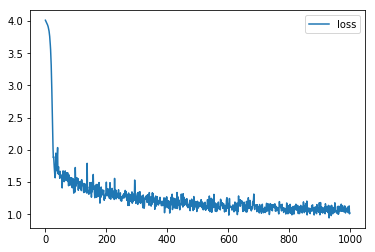

In [32]:
from IPython.display import clear_output
from random import sample

s.run(tf.global_variables_initializer())

batch_size = 32
history = []

for i in range(1000):
    batch = to_matrix(sample(names, batch_size), max_len=MAX_LENGTH)
    loss_i, _ = s.run([loss, optimize], {input_sequence: batch})
    
    history.append(loss_i)
    
    if (i + 1) % 100 == 0:
        clear_output(True)
        plt.plot(history, label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), 

In [33]:
x_t = tf.placeholder(tf.int32, (1,))
h_t = tf.Variable(np.zeros([1, rnn_num_units], np.float32))  
next_probs, next_h = rnn_one_step(x_t, h_t)

In [34]:
def generate_sample(seed_phrase=start_token, max_length=MAX_LENGTH):
  
    x_sequence = [token_to_id[token] for token in seed_phrase]
    s.run(tf.assign(h_t, h_t.initial_value))

    for ix in x_sequence[:-1]:
         s.run(tf.assign(h_t, next_h), {x_t: [ix]})

    for _ in range(max_length-len(seed_phrase)):
        x_probs,_ = s.run([next_probs, tf.assign(h_t, next_h)], {x_t: [x_sequence[-1]]})
        x_sequence.append(np.random.choice(n_tokens, p=x_probs[0]))
        
    return ''.join([tokens[ix] for ix in x_sequence if tokens[ix] != pad_token])

In [35]:
for _ in range(10):
    print(generate_sample())

 SellrinaNNNNNNN
 VamenetNNNNNNNN
 TiliNNNNNNNNNNN
 SannaNNNNNNNNNN
 LanmeNNNNNNNNNN
 ArmesNNNNNNNNNN
 rinbiolandeNNNN
 FosuledNNNNNNNN
 DonnseceNNNNNNN
 DoraNNNNNNNNNNN


In [36]:
for _ in range(10):
    print(generate_sample(' Trump'))

 TrumpianaNNNNNN
 TrumpedNNNNNNNN
 TrumpmeNNNNNNNN
 TrumpyyNNNNNNNN
 TrumpaaNNNNNNNN
 TrumpyNNNNNNNNN
 TrumpnaNNNNNNNN
 TrumpayNNNNNNNN
 TrumpitiNNNNNNN
 TrumpoeneNNNNNN
